In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import ParDMD, ParROM, DMD, ROM
import matplotlib.pyplot as plt
import time
import scipy.interpolate as si
import pandas as pd

In [2]:
dt = 3.0013e-2
## ======== Loading parameters =============
params = coor = pd.read_csv('../DATA/struc_doe_csv/params.csv', sep=';', 
                            engine='python', header=None, skiprows=2).stack().str.replace(',','.').unstack().to_numpy()[:, 1:3].astype(np.float)
p = params.shape[0]

for i in range(p):

    fln = "../DATA/struc_doe_csv/solid_disp_x_"+str(i+1)+".csv"
    with open(fln) as f:
        lines = (line for line in f if not line.startswith('#'))
        if i:
            u_x = np.concatenate((u_x, np.loadtxt(lines, delimiter=',',)), axis = 1)    ## -------------- solid x-displacement
        else:
            u_x = np.loadtxt(lines, delimiter=',',)
    fln = "../DATA/struc_doe_csv/solid_disp_y_"+str(i+1)+".csv"
    with open(fln) as f:
        lines = (line for line in f if not line.startswith('#'))
        if i:
            u_y = np.concatenate((u_y, np.loadtxt(lines, delimiter=',',)), axis = 1)    ## -------------- solid x-displacement
        else:
            u_y = np.loadtxt(lines, delimiter=',',)    ## -------------- solid x-displacement 

nx = u_x.shape[0]
ntt = int(u_x.shape[1]/p)

x = np.vstack((u_x, u_y))
X = x.swapaxes(0, 1).reshape((p, ntt, 2*nx),).swapaxes(1, 2)

train_t = np.arange(0, ntt)*dt

/var/folders/mp/h7b8hbp16j3dsm48zv_kfqzc0000gn/T/ipykernel_11619/2205085172.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  engine='python', header=None, skiprows=2).stack().str.replace(',','.').unstack().to_numpy()[:, 1:3].astype(np.float)


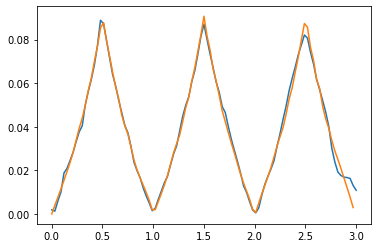

In [3]:
node = 100
X_ = X[2, :, :-1]
Y_ = X[2, :, 1::]
pred_t = train_t.copy()

dmd_ = DMD()
drom = ROM(dmd_)
drom.decompose(X = X_, Y = Y_, dt = dt, normalize=True, rank=0)

predd = np.real(drom.predict(pred_t, method=2, t1= dt))
plt.plot(pred_t, predd[nx-node]);
plt.plot(train_t[:-1], X_[nx-node, :]);

In [14]:
dmd_red = DMD()
dromred = ROM(dmd_red)
X_r = pard.pod_.modes.T @ X_
Y_r = pard.pod_.modes.T @ Y_
dromred.decompose(X = X_r, Y = Y_r, dt = dt, normalize=True, rank=0)
preddred = pard.pod_.modes @ np.real(dromred.predict(pred_t, method=2))
plt.plot(pred_t, preddred[nx-node]);
plt.plot(train_t[:-1], X_[nx-node, :]);

NameError: name 'pard' is not defined

In [5]:
choose = [0, 1, 2,3,4, 5,6, 7,8,9,10,11]
pard = ParDMD()
muROM = ParROM(pard)

muROM.decompose(X = X[choose, :, :], params = params[choose, :].T, dt = dt, normalize = False, rank = 0)

In [6]:
test_mu = np.array([[8.37329579, -2.]])
test_mu = np.array([[2., -6.]])

pred_t = train_t.copy()

result_ = np.real(muROM.predict(pred_t, test_mu, stabilize=False, method=2, kernel='cubic'))

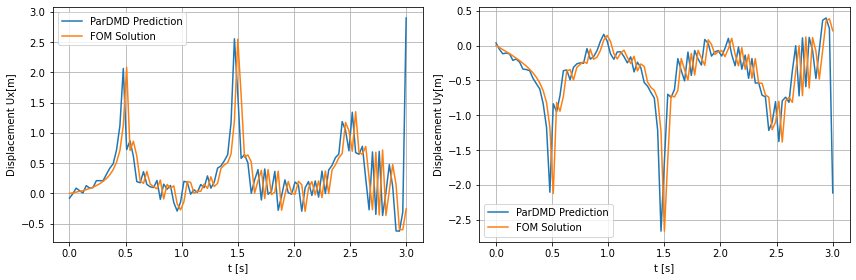

In [8]:
node = 100
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(pred_t, result_[nx-node, :], label = "ParDMD Prediction");
ax[0].plot(train_t, X[0, nx-node, :], label = "FOM Solution");
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("Displacement Ux[m]");
#ax[0].set_title("Velocity at x/L =  " + str(L * (nx - node + 1)/nx));
#ax[0].axvline(train_t[-1], color = 'r', label = "Training regime");
ax[0].legend();

ax[1].plot(pred_t, result_[2*nx-node, :], label = "ParDMD Prediction");
ax[1].plot(train_t, X[0, 2*nx-node, :], label = "FOM Solution");
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("Displacement Uy[m]");
#ax[1].set_title("Pressure at x/L =  " + str(L * (nx - node + 1)/nx));
#ax[1].axvline(train_t[-1], color = 'r', label = "Training regime");
ax[1].legend();

fig.tight_layout();

In [158]:
params.shape

(12, 2)

In [159]:
X.shape

(12, 294, 101)

In [157]:
from rom_am import ManDMD

In [146]:
choose = [0, 1, 2,3, 5,6, 7,8,9,10,11]
mndmd = ManDMD()
manROM = ParROM(mndmd)

manROM.decompose(X = X[choose, :, :], params = params[choose, :].T, dt = dt, normalize = False, rank = 0, kernel = 'linear')

In [151]:
test_mu = np.array([[2., -2.]])
pred = manROM.predict(pred_t, test_mu, stabilize=True, method=1, init=X[1, :, 20], t1 = train_t[20])

In [152]:
pred_tst = np.empty((mndmd.dpd.modes.shape[1], X.shape[2]-20))
pred_tst[:, 0] = (mndmd.dpd.modes.T @ X[1, :, 20].reshape((-1, 1))).ravel()
for i in range(X.shape[2]-21):
    pred_tst[:, i+1] = mndmd.dpd.A_tilde @ pred_tst[:, i]
pred_tst = mndmd.dpd.modes @ pred_tst

/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


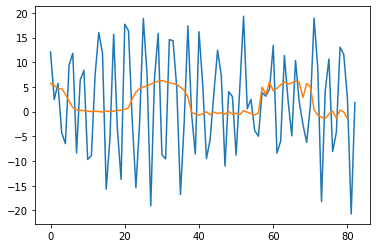

In [155]:
plt.plot(pred[nx-node, 18::])
plt.plot(X[1, nx-node, 20::], '-');
#plt.plot(pred_tst[nx-node, :], '.-');

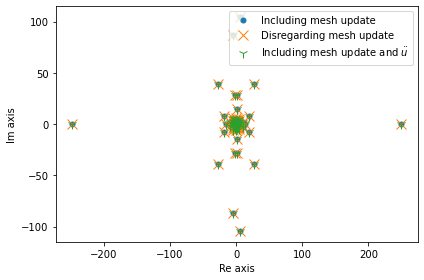

In [156]:
plt.plot(np.real(mndmd.dpd.lambd), np.imag(mndmd.dpd.lambd), '.', markersize = 10, label = "Including mesh update");
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.plot(np.real(mndmd.dpd.lambd), np.imag(mndmd.dpd.lambd), 'x', markersize = 10, label = "Disregarding mesh update");
plt.plot(np.real(mndmd.dpd.lambd), np.imag(mndmd.dpd.lambd), '1', markersize = 10, label = r"Including mesh update and $\ddot{u}$");
plt.legend();
plt.tight_layout();